# Trabalho 2 - Narmax e modelos não-lineares
Disciplina:
- TE975 - Controle Avançado

Autores:
- Ana Paula da Silva Pelegrini GRR20177221
- Caio Phillipe Mizerkowski GRR20166403

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [188]:
with open('../data/SNLS80mV.csv','r') as f:
    data1 = np.loadtxt(f,delimiter=',')

with open('../data/DATAPRBS.csv','r') as f:
    data2 = np.loadtxt(f,delimiter=',',skiprows=1)
    data2 = data2[:350,[3,2]]

# Narmax Model

In [49]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.display_results import results

## Sinal 1

In [5]:
n_cols = data2.shape[0]
p = 0.8
x_valid, y_valid = data1[int(n_cols*p):,0].reshape(-1,1), data1[int(n_cols*p):,1].reshape(-1,1)
x_train, y_train = data1[:int(n_cols*p),0].reshape(-1,1), data1[:int(n_cols*p),1].reshape(-1,1)

##### Extraindo o modelo para alta não-linearidade e memória
Utilizando inicialmente um polinomio de quinto grau (nl=5), os parametros ny,nu,ne = 6 e a quantidade de coeficientes igual a 10:

In [43]:
basis_function = Polynomial(degree=5)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=6,
    xlag=6,
    elag=6,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_train, y=y_train);

Vemos que o maior efeito de não-linearidade encontrado foi com o nl=3 e que os 6 primeiros coeficientes são os mais relevantes.

In [44]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f'MSE do treinamento: {mse}')
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f'MSE da validação: {mse}')
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=5, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

MSE do treinamento: 4.373424873610112e-06
MSE da validação: 5.596604967648836e-06


,Regressors,Parameters,ERR
0,y(k-4),-0.0700,0.67271
1,y(k-1),1.3570,0.19745
2,y(k-2),-0.8346,0.10486
3,x1(k-1),0.4520,0.02298
4,1,-0.0029,0.00166
5,y(k-1)^3,-1.4421,0.00012
6,x1(k-3),0.1190,0.00002
7,x1(k-4),-0.0583,0.00005
8,x1(k-5),0.0284,0.00003
9,y(k-3)y(k-2)y(k-1),-1.1952,0.00003


Podemos com base nisso simplificar o modelo:

In [45]:
basis_function = Polynomial(degree=3)

model = FROLS(
    order_selection=True,
    n_info_values=6,
    extended_least_squares=False,
    ylag=4,
    xlag=1,
    elag=0,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_train, y=y_train);

Ao simplificarmos o modelo, os mse de treinamento e validação são reduzidos em uma escala de grandeza, mas também o tempo de processamento.

In [46]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f'MSE do treinamento: {mse}')
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f'MSE da validação: {mse}')
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=5, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

MSE do treinamento: 1.4739508112520084e-05
MSE da validação: 2.0045836191739242e-05


,Regressors,Parameters,ERR
0,y(k-4),0.0246,0.67270
1,y(k-1),1.5135,0.19743
2,y(k-2),-0.9680,0.10487
3,x1(k-1),0.4090,0.02298
4,1,-0.0021,0.00166
5,y(k-1)^3,-1.4477,0.00012


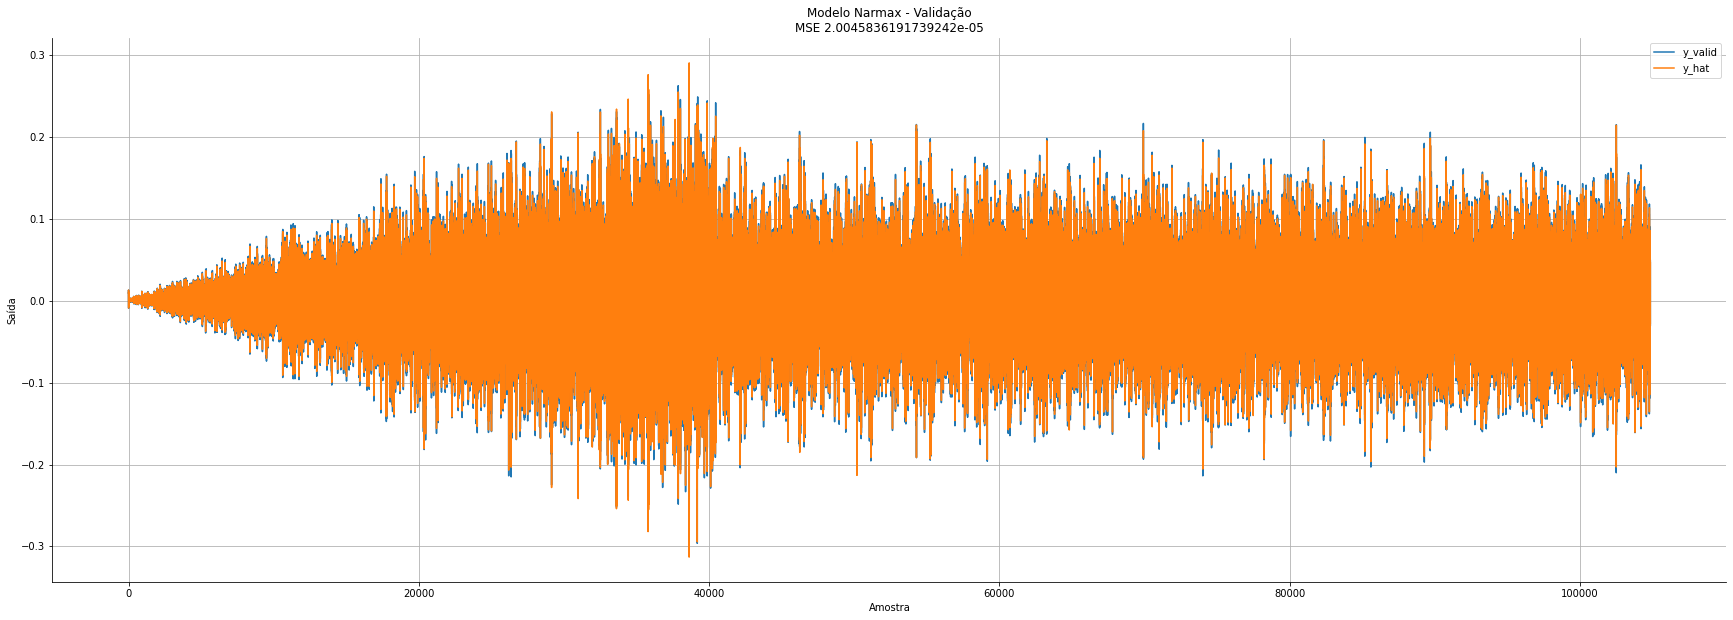

In [47]:
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize = (30,10))
t = np.arange(y_valid.size)
sns.lineplot(x=t,y=y_valid.flatten(),label='y_valid')
sns.lineplot(x=t,y=yhat.flatten(),label='y_hat')
plt.title(f'Modelo Narmax - Validação\nMSE {mse}')
plt.xlabel('Amostra')
plt.ylabel('Saída')

plt.grid()
plt.show()
plt.close()

## Sinal 2

In [189]:
n_cols = data2.shape[0]
data2[:,1] = data2[:,1]/data2[:,1].std()
p = 0.8
x_valid, y_valid = data2[int(n_cols*p):,0].reshape(-1,1), data2[int(n_cols*p):,1].reshape(-1,1)
x_train, y_train = data2[:int(n_cols*p),0].reshape(-1,1), data2[:int(n_cols*p),1].reshape(-1,1)

##### Extraindo o modelo para alta não-linearidade e memória
Em razão da dificuldade de se conseguir um bom chute inicial para os parametros, foi realizado um loop por diferentes configurações para se extrair o melhor modelo.

In [ ]:
from itertools import product
p = product(range(1,5),range(1,8),range(1,8))
for l, yl, xl in p:
    basis_function = Polynomial(degree=l)

    model = FROLS(
        order_selection=True,
        n_info_values=20,
        extended_least_squares=False,
        ylag=yl,
        xlag=xl,
        elag=0,
        info_criteria='aic',
        estimator='least_squares',
        basis_function=basis_function
    )
    print(f'l: {l}, yl: {yl}, xl: {xl}')
    model.fit(X=x_train, y=y_train);
    yhat = model.predict(X=x_train, y=y_train)
    mse = mean_squared_error(y_train, yhat)
    print(f'MSE do treinamento: {mse}')
    yhat = model.predict(X=x_valid, y=y_valid)
    mse = mean_squared_error(y_valid, yhat)
    print(f'MSE da validação: {mse}')

In [193]:
basis_function = Polynomial(degree=4)

model = FROLS(
    order_selection=True,
    n_info_values=20,
    extended_least_squares=False,
    ylag=5,
    xlag=7,
    elag=0,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_train, y=y_train);

O melhor modelo encontrando possui uma não-linearidade de quarto grau, ny=5 e nu=7.

In [194]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f'MSE do treinamento: {mse}')
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f'MSE da validação: {mse}')
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=5, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

MSE do treinamento: 0.3182150787298546
MSE da validação: 0.3810140781771482


,Regressors,Parameters,ERR
0,y(k-1),0.9347,0.95302
1,x1(k-1)^2y(k-2)^2,-0.6827,0.02821
2,y(k-4)y(k-1)^3,-0.0118,0.00800
3,x1(k-7)x1(k-4)x1(k-1)^2,0.0403,0.00292
4,x1(k-7)x1(k-4)y(k-2),-0.0662,0.00120
5,y(k-1)^3,-0.4296,0.00069
6,x1(k-1)^2y(k-3)^2,0.3298,0.00167
7,y(k-1)^4,0.0165,0.00077
8,y(k-3)y(k-1)^3,-0.0269,0.00116
9,y(k-5)^2y(k-3),-0.0600,0.00018


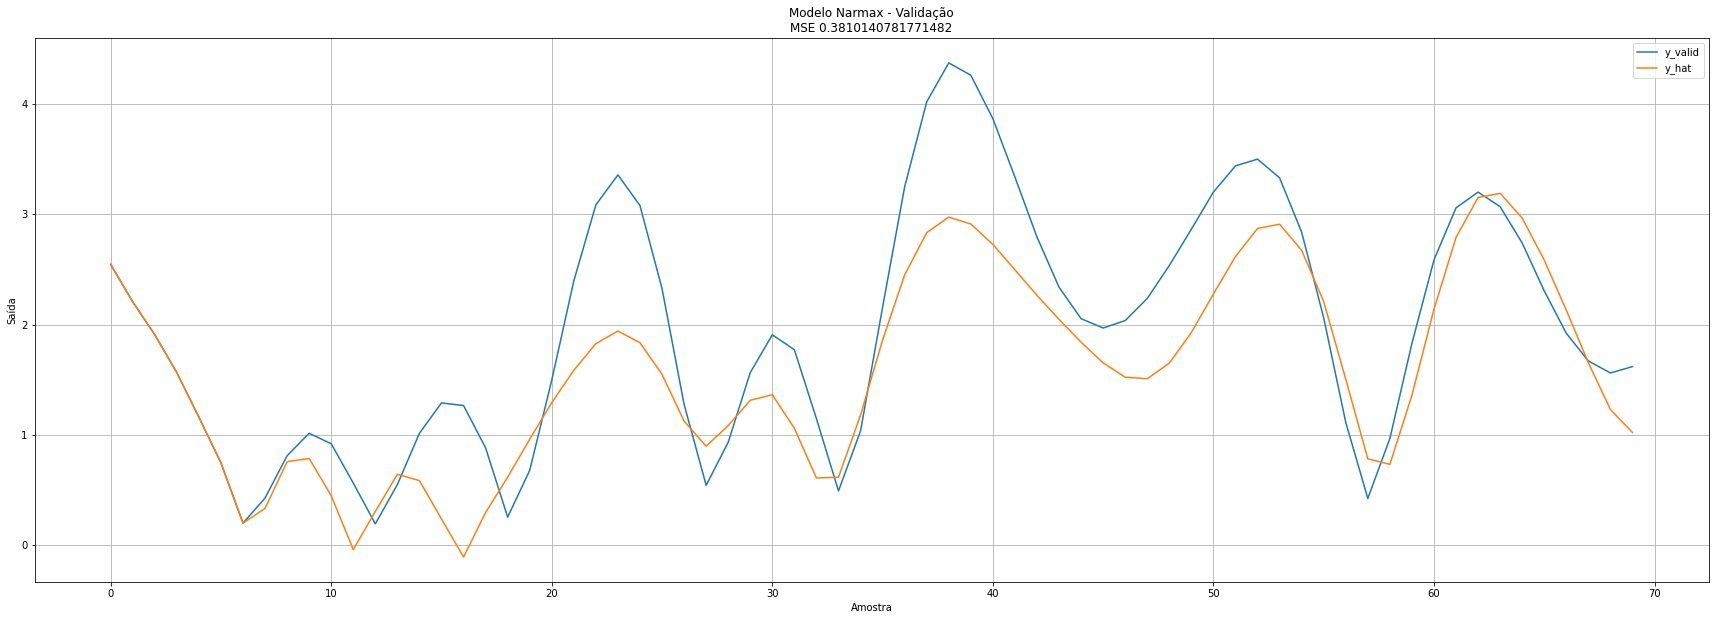

In [196]:
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize = (30,10))
t = np.arange(y_valid.size)
sns.lineplot(x=t,y=y_valid.flatten(),label='y_valid')
sns.lineplot(x=t,y=yhat.flatten(),label='y_hat')
plt.title(f'Modelo Narmax - Validação\nMSE {mse}')
plt.xlabel('Amostra')
plt.ylabel('Saída')

plt.grid()
plt.show()
plt.close()